## Access SOOP XBT NRT data in Parquet

A jupyter notebook to show how to access and plot SOOP XBT NRT data available as a [Parquet](https://parquet.apache.org) dataset on S3

In [1]:
dataset_name = "vessel_xbt_realtime_nonqc"

## Install/Update packages and Load common functions

In [2]:
# only run once, then restart session if needed
!pip install uv

import os
import sys

def is_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

# Get the current directory of the notebook
current_dir = os.getcwd()

# Check if requirements.txt exists in the current directory
local_requirements = os.path.join(current_dir, 'requirements.txt')
if os.path.exists(local_requirements):
    requirements_path = local_requirements
else:
    # Fall back to the online requirements.txt file
    requirements_path = 'https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/notebooks/requirements.txt'

# Install packages using uv and the determined requirements file
if is_colab():
    os.system(f'uv pip install --system -r {requirements_path}')
else:
    os.system('uv venv')
    os.system(f'uv pip install -r {requirements_path}')

Using Python 3.12.4 interpreter at: /home/lbesnard/miniforge3/envs/AodnCloudOptimised/bin/python3
Creating virtualenv at: .venv
Activate with: source .venv/bin/activate
Audited 127 packages in 74ms


In [3]:
import requests
import os
if not os.path.exists('parquet_queries.py'):
  print('Downloading parquet_queries.py')
  url = 'https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/aodn_cloud_optimised/lib/ParquetDataQuery.py'
  response = requests.get(url)
  with open('parquet_queries.py', 'w') as f:
      f.write(response.text)

In [4]:
from parquet_queries import create_time_filter, create_bbox_filter, query_unique_value, plot_spatial_extent, get_spatial_extent, get_temporal_extent, get_schema_metadata
import pyarrow.parquet as pq
import pyarrow.dataset as pds
import pyarrow as pa
import os
import pandas as pd
import pyarrow.compute as pc

## Location of the parquet dataset

In [5]:
BUCKET_OPTIMISED_DEFAULT="aodn-cloud-optimised"
dname = f"s3://anonymous@{BUCKET_OPTIMISED_DEFAULT}/{dataset_name}.parquet/"
parquet_ds = pq.ParquetDataset(dname,partitioning='hive')

# Understanding the Dataset

## Get partition keys
Partitioning in Parquet involves organising data files based on the values of one or more columns, known as partition keys. When data is written to Parquet files with partitioning enabled, the files are physically stored in a directory structure that reflects the partition keys. This directory structure makes it easier to retrieve and process specific subsets of data based on the partition keys.

In [6]:
dataset = pds.dataset(dname, format="parquet", partitioning="hive")

partition_keys = dataset.partitioning.schema
print(partition_keys)

XBT_line: string
timestamp: int32
polygon: string


## List unique partition values

In [7]:
%%time
unique_partition_value = query_unique_value(parquet_ds, 'XBT_line')
print(list(unique_partition_value)[0:2])  # showing a subset only

['PX06', 'PX32']
CPU times: user 9.3 ms, sys: 261 µs, total: 9.57 ms
Wall time: 8.89 ms


## Visualise Spatial Extent of the dataset
In this section, we're plotting the polygons where data exists. This helps then with creating a bounding box where there is data

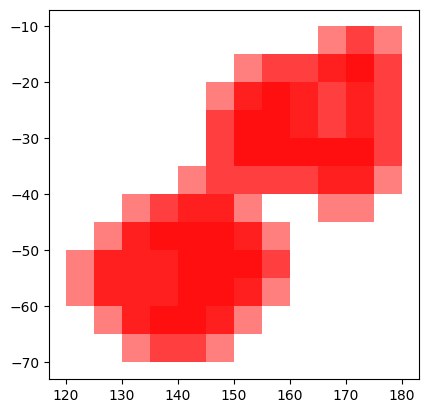

In [8]:
plot_spatial_extent(parquet_ds)

## Get Temporal Extent of the dataset

Similary to the spatial extent, we're retrieving the minimum and maximum timestamp partition values of the dataset. This is not necessarely accurately representative of the TIME values, as the timestamp partition can be yearly/monthly... but is here to give an idea

In [9]:
get_temporal_extent(parquet_ds)

(datetime.datetime(2020, 9, 1, 10, 0), datetime.datetime(2024, 6, 1, 10, 0))

## Read Metadata

For all parquet dataset, we create a sidecar file in the root of the dataset named **_common_matadata**. This contains the variable attributes.

In [10]:
# parquet_meta = pa.parquet.read_schema(os.path.join(dname + '_common_metadata'))  # parquet metadata
metadata = get_schema_metadata(dname)  # schema metadata
metadata

{'TIME': {'type': 'timestamp[ns]',
  'standard_name': 'time',
  'long_name': 'time',
  'axis': 'T',
  'valid_min': 0.0,
  'valid_max': 90000.0},
 'LATITUDE': {'type': 'double',
  'standard_name': 'latitude',
  'long_name': 'latitude',
  'units': 'degrees_north',
  'axis': 'Y',
  'valid_min': -90.0,
  'valid_max': 90.0,
  'reference_datum': 'WGS84 coordinate reference system'},
 'LONGITUDE': {'type': 'double',
  'standard_name': 'longitude',
  'long_name': 'longitude',
  'units': 'degrees_east',
  'axis': 'X',
  'valid_min': -180.0,
  'valid_max': 180.0,
  'reference_datum': 'WGS84 coordinate reference system'},
 'DEPTH': {'type': 'double',
  'axis': 'Z',
  'long_name': 'depth',
  'positive': 'down',
  'reference_datum': 'sea surface',
  'standard_name': 'depth',
  'units': 'm',
  'ancillary_variables': 'DEPTH_quality_control',
  'valid_max': 12000.0,
  'valid_min': -5.0,
  'fallrate_equation_coefficient_a': 6.691,
  'fallrate_equation_coefficient_b': -2.25},
 'DEPTH_quality_control': {

# Data Query and Plot

## Create a TIME and BoundingBox filter

In [11]:
filter_time = create_time_filter(parquet_ds, date_start='2023-01-31 10:14:00', date_end='2024-02-01 07:50:00')
filter_geo = create_bbox_filter(parquet_ds, lat_min=-34, lat_max=-32, lon_min=150, lon_max=155)


filter = filter_geo & filter_time

In [12]:
%%time
# using pandas instead of pyarrow so that filters can directly be applied to the data, and not just the partition
df = pd.read_parquet(dname, engine='pyarrow',filters=filter)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14193 entries, 0 to 14192
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   TIME                   14193 non-null  datetime64[ns]
 1   LATITUDE               14193 non-null  float64       
 2   LONGITUDE              14193 non-null  float64       
 3   DEPTH                  14193 non-null  float64       
 4   DEPTH_quality_control  14193 non-null  float32       
 5   TEMP                   14193 non-null  float64       
 6   TEMP_quality_control   14193 non-null  float32       
 7   imo_number             14193 non-null  int32         
 8   ship_name              14193 non-null  object        
 9   Callsign               14193 non-null  object        
 10  filename               14193 non-null  object        
 11  XBT_line               14193 non-null  category      
 12  timestamp              14193 non-null  category      
 13  p

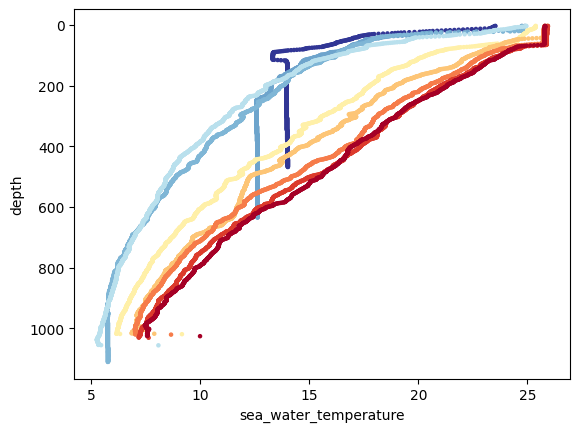

In [13]:
df[df['TEMP_quality_control'] == 1].sort_values('TIME').plot.scatter(x='TEMP', y='DEPTH', c='TIME', 
                                                                     xlabel=metadata['TEMP']['standard_name'],
                                                                     ylabel=metadata['DEPTH']['standard_name'],
                                                                     cmap='RdYlBu_r', marker='.', linestyle="None").invert_yaxis()

## Create a TIME and scalar/number filter

In [14]:
filter_time = create_time_filter(parquet_ds, date_start='2024-01-31 10:14:00', date_end='2024-02-01 07:50:00')

expr_1 = pc.field('XBT_line') == pa.scalar("PX34")
filter = expr_1 & filter_time

In [15]:
%%time
# using pandas instead of pyarrow so that filters can directly be applied to the data, and not just the partition
df = pd.read_parquet(dname, engine='pyarrow',filters=filter)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12616 entries, 0 to 12615
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   TIME                   12616 non-null  datetime64[ns]
 1   LATITUDE               12616 non-null  float64       
 2   LONGITUDE              12616 non-null  float64       
 3   DEPTH                  12616 non-null  float64       
 4   DEPTH_quality_control  12616 non-null  float32       
 5   TEMP                   12616 non-null  float64       
 6   TEMP_quality_control   12616 non-null  float32       
 7   imo_number             12616 non-null  int32         
 8   ship_name              12616 non-null  object        
 9   Callsign               12616 non-null  object        
 10  filename               12616 non-null  object        
 11  XBT_line               12616 non-null  category      
 12  timestamp              12616 non-null  category      
 13  p

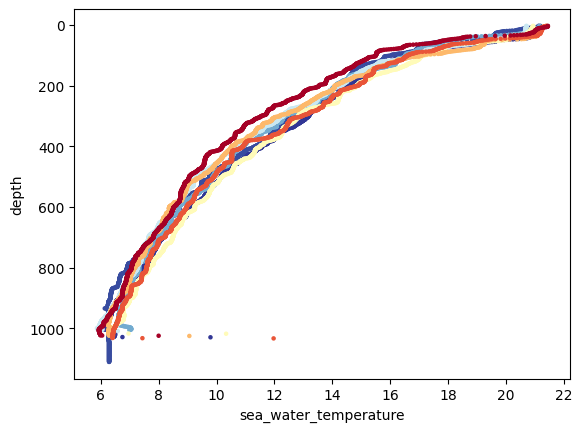

In [16]:
## Plotting only Good Quality data using QC flags
df[df['TEMP_quality_control'] == 1].sort_values('TIME').plot.scatter(x='TEMP', y='DEPTH', c='TIME', cmap='RdYlBu_r',
                                                                     xlabel=metadata['TEMP']['standard_name'],
                                                                     ylabel=metadata['DEPTH']['standard_name'],
                                                                     marker='.', linestyle="None").invert_yaxis()